# RiFNetII

## Prediction

In [1]:
import cv2
import numpy as np
from scipy import stats
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras import optimizers
import math
import os, glob
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from natsort import natsorted
#os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
#config = tf.compat.v1.ConfigProto()
#config.gpu_options.allow_growth = True
#sess = tf.compat.v1.InteractiveSession(config=config)

In [2]:
from sklearn.metrics import f1_score
def weighted_f1(y_true, y_pred):
    
    y_true = np.argmax(y_true.numpy(), axis=1).flatten()
    y_pred = np.argmax(y_pred.numpy(), axis=1).flatten()
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    return f1

In [3]:
image_path = '/Users/victor/Desktop/work/Institute_of_Forensic_Medicine/gui_rifnet/images' 
image_list = natsorted(os.listdir(image_path))
if image_list[0] == '.DS_Store':
    image_list = image_list[1:]


# define optimizer
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.metrics import Precision, Recall
#os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
learning_rate = 0.00015
opt = Adam(lr=0.0001)
loss_type = 'categorical_crossentropy' 

model_path = '/Users/victor/Desktop/work/Institute_of_Forensic_Medicine/gui_rifnet/ResNet50_full_model.h5'

dependencies = {
    'weighted_f1': weighted_f1
}
model = tf.keras.models.load_model(model_path, custom_objects=dependencies, compile=False)
model.compile(loss=loss_type,
                  optimizer=opt,
                  metrics=[Precision(),Recall(),weighted_f1], run_eagerly=True)



source_dir = '/Users/victor/Desktop/work/Institute_of_Forensic_Medicine/gui_rifnet/toy_data'
classes = os.listdir(source_dir)
classes = [x for x in classes if x != '.DS_Store']
classes2 = classes.copy()
classes2.remove('no_fracture')

color_list_fill = [(255,102,255),(102,255,102),(102,255,255),(102,102,255),(107,178,255),(255,102,102),(255,171,102)]
color_list_box = [(255,0,255),(0,255,0),(0,255,255),(0,0,255),(0,128,255),(255,0,0),(234,123,10)]

# create target folder
source_path = '/Users/victor/Desktop/work/Institute_of_Forensic_Medicine/gui_rifnet'
pred_path = os.path.join(source_path,'prediction_images_data_all_frac_with_mult')
if not os.path.isdir(pred_path):
    os.makedirs(pred_path)

len(image_list),classes,classes2

2023-06-19 16:53:04.632803: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-19 16:53:04.634708: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.


(1,
 ['nondisplaced',
  'displaced_long_cum_dist',
  'displaced_long_cum_cont',
  'no_fracture',
  'displaced_latus'],
 ['nondisplaced',
  'displaced_long_cum_dist',
  'displaced_long_cum_cont',
  'displaced_latus'])

In [4]:
os.path.basename(image_path)

'images'

In [5]:
# upscale images
def upscale(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED) 
    img = img[250:750, 150:1150]
    scale_percent = 300 # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA) # resize image
    return resized

In [6]:
# sub-divide images into small images
def sub_divide(resized):
    
    mapping_array = np.zeros((int(resized.shape[0]/50),int(resized.shape[1]/50)))
    small_img_list = []
    coord_list = []
    shift = 50
    
    for m in range(0,resized.shape[0]-shift,shift):
        for n in range(0,resized.shape[1]-shift,shift):
            small_img = resized[m:m+99,n:n+99]
            if np.mean(small_img) < 1:
                mapping_array[int(m/50)][int(n/50)] = 0
                continue
            else:
                small_img = small_img/255.
                small_img_list.append(small_img)
                coord_list.append([m,n])
                mapping_array[int(m/50)][int(n/50)] = 1
                
    return small_img_list, coord_list, m, n, mapping_array

In [7]:
def predict(small_img_list, model):
    
    small_img_arr = np.array(small_img_list)
    results_prob = model.predict(small_img_arr)
    results = np.argmax(results_prob,axis=1)
    #results = model.predict_classes(small_img_arr)
    #results_prob = model.predict_proba(small_img_arr)
    #print('predicted on current images...')
    return results, results_prob

In [8]:
def create_reduced_array(arr,results):
    
    cnt = 0
    
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            
            if arr[i][j] == 0:
                continue
                
            else:

                if results[cnt] == 3:
                    arr[i][j] = 0

                if results[cnt] != 3:
                    arr[i][j] = 1

                cnt += 1
                    
    return arr

In [9]:
def get_multiple_coords(mapped_arr):
    
    coord = []
    arr = np.transpose(mapped_arr)

    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            if arr[i][j] == 1:
                coord.append([i,j])
                
    coord_flipped = [[x[1],x[0]] for x in coord]
    
    full_list = []
    flex_list = []
    min_dist = 1 # integer
    
    for t in range(0,len(coord_flipped)-1):

        if coord_flipped[t+1][1] - coord_flipped[t][1] <= min_dist:
            flex_list.append(coord_flipped[t])

        if coord_flipped[t+1][1] - coord_flipped[t][1] <= min_dist and t == len(coord_flipped)-2:
            flex_list.append(coord_flipped[t+1])
            full_list.append(flex_list)

        elif coord_flipped[t+1][1] - coord_flipped[t][1] > min_dist:
            flex_list.append(coord_flipped[t])
            full_list.append(flex_list)
            flex_list = []
    
    nb_hits = 7
    coord_list = []
    for i in range(len(full_list)):
        if len(full_list[i]) > nb_hits:
            c0 = [x[0] for x in full_list[i]]
            c1 = [x[1] for x in full_list[i]]
            coord_list.append([np.min(list(set(c0))),np.max(list(set(c0))),
                              np.min(list(set(c1))),np.max(list(set(c1)))])
    
    return coord_list

In [10]:
def draw_rect(resized, results, results_prob, coord_list, cnt,m,n):
    
    overlay = resized.copy()
    
    # create prediction matrix
    rows = resized.shape[0]
    cols = resized.shape[1]
    dim = (int((rows/99)*2),int((cols/99)*2))
    pred_matrix = np.zeros((m,n))
    
    # create legend (boxes) in images
    for c in range(len(classes2)):
        l = c*60
        current_color_fill = color_list_fill[c]
        current_color_box = color_list_box[c]
        overlay[50+l:99+l,50:99] = current_color_fill
        cv2.rectangle(resized, (50,50+l), (99,99+l), current_color_box, thickness = 2)
        
    # create prediction frames on images for each class
    row = 0
    for r in range(len(results)):
        
        if r != 0 and r % rows == 0:
            row += 1
            
        current_coordinates = coord_list[r]
        m = current_coordinates[0]
        n = current_coordinates[1]
        
        if results[r] == 3:
            continue
        
        elif results[r] != 3:  #and results_prob[r][results[r]] > 0.7:
            #pred_matrix[row][r] = 1
            current_color_fill = color_list_fill[results[r]-1]
            current_color_box = color_list_box[results[r]-1]
            '''
            if results[r] == 2 or results[r] == 3:
                current_color_fill = color_list_fill[results[r]-1]
                current_color_box = color_list_box[results[r]-1]
            else:
                current_color_fill = color_list_fill[results[r]]
                current_color_box = color_list_box[results[r]]
            '''
            #current_coordinates = coord_list[r]
             #m = current_coordinates[0]
             #n = current_coordinates[1]
            overlay[m:m+99,n:n+99] = current_color_fill
            cv2.rectangle(resized, (n,m), (n+99,m+99), current_color_box, thickness = 2)
            #add = cv2.addWeighted(overlay,0.4,resized,1,0)
    
    # merge all together and save image
    add = cv2.addWeighted(overlay,0.4,resized,0.6,0)
    resized = add
    
    # create legend (writing) in images
    for c in range(len(classes2)):
        l = c*60
        cv2.putText(resized, classes2[c], (120, 85+l), cv2.FONT_HERSHEY_SIMPLEX , 1,(255, 255, 255), 3, cv2.LINE_AA, False)
    
    # add multiple rectangle
    #for i in coord_multiple_list:
        #cv2.rectangle(resized, (i[2]*50,i[0]*50), ((i[3]*50)+100,(i[1]*50)+100), (30,30,240), thickness = 3)
        
    cv2.imwrite(os.path.join(pred_path, 'test_fracture_%d.jpg' % cnt), resized)
    


In [31]:
cnt = 1
for img in image_list:
    if cnt % 50 == 0:
        print('processed images: ', cnt)
    if '.jpg' not in img:
        continue
    
    else:
        current_path = os.path.join(image_path,img)
        resized = upscale(current_path)
        small_img_list,coord_list,m,n,mapping_array = sub_divide(resized)
        results,results_prob = predict(small_img_list, model)
        mapped_array = create_reduced_array(mapping_array, results)
        coord_multiple_list = get_multiple_coords(mapped_array)
        draw_rect(resized,results,results_prob,coord_list,cnt,m,n)
        cnt += 1

    

In [105]:
cnt = 1
for img in image_list:
    if cnt % 50 == 0:
        print('processed images: ', cnt)
    if '.jpg' not in img:
        continue
    
    else:
        current_path = os.path.join(image_path,img)
        resized = upscale(current_path)
        small_img_list,coord_list,m,n,mapping_array = sub_divide(resized)
        results,results_prob = predict(small_img_list, model)
        #mapped_array = create_reduced_array(mapping_array, results)
        #coord_multiple_list = get_multiple_coords(mapped_array)
        #draw_rect(resized,results,results_prob,coord_list,cnt,m,n)
        cnt += 1

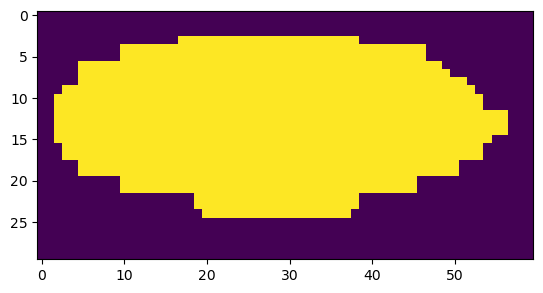

In [12]:
plt.imshow(mapping_array)

In [90]:
test = [i[0] for i in list(results_prob[:,4:5])]

In [89]:
def create_hm(coords, attention_map, patch_size):
    max_vals = np.amax(coords,axis=0)
    placeholder = np.zeros(((resized.shape[0]),(resized.shape[1])))
    for i in range(len(attention_map)):
        placeholder[(coords[i][0]):(coords[i][0])+patch_size,(coords[i][1]):(coords[i][1])+patch_size] = attention_map[i]
    return placeholder

In [93]:
placeholder = create_hm(coord_list,np.array(test),99)

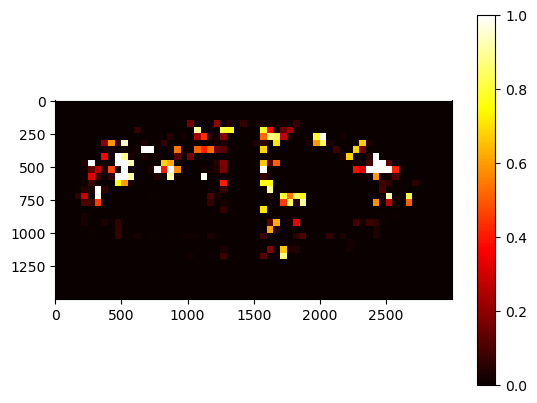

In [94]:
plt.imshow(placeholder, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

In [86]:
len(test),len(coord_list)

(928, 928)

(1500, 3000, 3) (1500, 3000, 3)


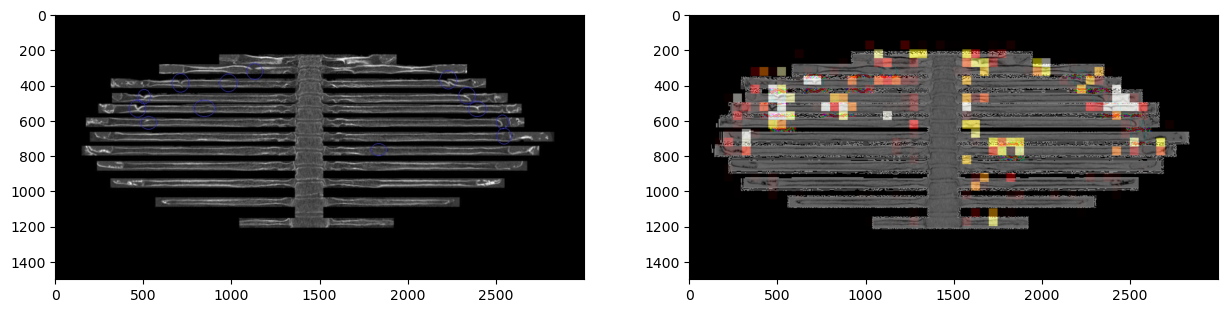

In [87]:
overlay2 = (placeholder*255).astype(np.uint8)
heatmap_img = cv2.applyColorMap(overlay2, cv2.COLORMAP_HOT)
resized2 = (resized*255).astype(np.uint8)
final=cv2.addWeighted(resized2,0.5,heatmap_img,0.5,0)
final_rgb = cv2.cvtColor(final, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(15,15))
plt.subplot(1, 2, 1)
plt.imshow(resized)
plt.subplot(1, 2, 2)
plt.imshow(final_rgb)

In [136]:
class_masks_holder = []

for i in range(len(classes)):
    
    img_to_process = resized.copy()
    overlay = resized.copy()
    rows = resized.shape[1]

    row = 0
    for r in range(len(results)):
            
        if r != 0 and r % rows == 0:
            row += 1
            
        current_coordinates = coord_list[r]
        m = current_coordinates[0]
        n = current_coordinates[1]
        
        if results[r] == i:  
            current_color_fill = color_list_fill[i]
            overlay[m:m+99,n:n+99] = current_color_fill


    # merge all together and save image

    class_masks_holder.append(overlay)
    #add = cv2.addWeighted(overlay,0.4,resized,0.6,0)
    #img_to_process = add
    #plt.imshow(img_to_process)
    #plt.show()
    #plt.close()
    

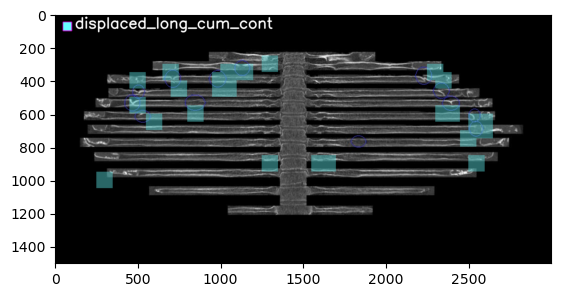

In [164]:
class_to_display = 2
img_to_process = resized.copy()
add = cv2.addWeighted(class_masks_holder[class_to_display],0.4,resized,0.6,0)
add[50:99,50:99] = color_list_fill[class_to_display]
img_to_process = add
cv2.putText(img_to_process, classes[class_to_display], (120, 85), cv2.FONT_HERSHEY_SIMPLEX , 3, (255, 255, 255), 7, cv2.LINE_AA, False)
plt.imshow(img_to_process)
plt.show()